# Multivariate time series forecast using Recurrent Neural Networks

In this notebook I have analyzed a multivariate time series representing the total sales of different types of goods from 1993 to 2020 in the U.S.
Data have been taken from here:
https://fred.stlouisfed.org/categories/33203?cid=33203&et=&pageID=3&t=
The dataset used in this notebook has been created by aggregating 4 different time series representing the sales of 4 types of goods (alcohol, groceries, household appliances and furniture).

The target is to create a model able to predict the future sales (12 months in the future) in the 4 different categories. This has been done by Recurrent Neural Networks (RNN). In particular, two types of architecture have been used:
* LSTM (Long-Short Term Memory)
* GRU (Gated Recurrent Unit)

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("../input/fred-sales-v2/Sales.csv",index_col='DATE',parse_dates=True)

In [3]:
df.head()

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
1992-01-01,3459.0,22506.0,8932,2297
1992-02-01,3458.0,21494.0,8779,2259
1992-03-01,4002.0,23277.0,9475,2688
1992-04-01,4564.0,23154.0,9020,2612
1992-05-01,4221.0,22804.0,8558,2472


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 1992-01-01 to 2020-01-01
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   alcohol sales              337 non-null    float64
 1   grocery sales              337 non-null    float64
 2   household appliance sales  337 non-null    int64  
 3   furniture sales            337 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 13.2 KB


In [5]:
df.describe()

,alcohol sales,grocery sales,household appliance sales,furniture sales
count,337.000000,337.000000,337.000000,337.000000
mean,8077.498516,38075.471810,28321.899110,4987.311573
std,3043.216147,10785.360357,13073.343972,1575.691045
min,3031.000000,21215.000000,8558.000000,2242.000000
25%,5342.000000,28851.000000,17393.000000,3786.000000
50%,7710.000000,36098.000000,25169.000000,4884.000000
75%,10453.000000,47155.000000,40140.000000,5972.000000
max,16197.000000,61505.000000,58441.000000,9120.000000


In [6]:
df.isnull().sum()

alcohol sales                0
grocery sales                0
household appliance sales    0
furniture sales              0
dtype: int64

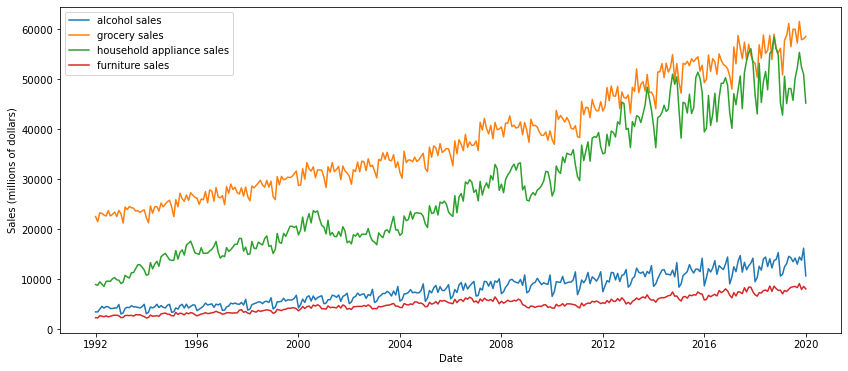

In [7]:
fig, ax = plt.subplots(figsize=(14,6))

ax.set_xlabel('Date')
ax.set_ylabel('Sales (millions of dollars)')

for feat in df.columns:
    ax.plot(df.index, df[feat], label=feat)

legend = ax.legend()
plt.show()

All four series show a similar pattern (yearly pattern), with lows and highs in the same season - we expect a high correlation between the series.

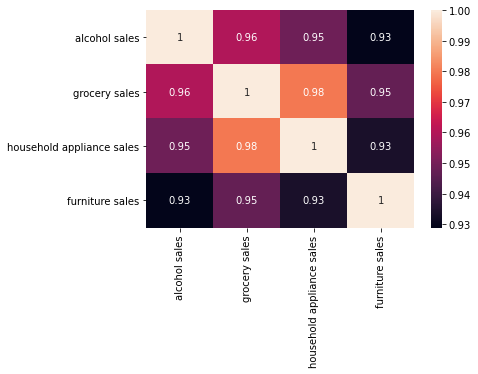

In [8]:
sns.heatmap(df.corr(),annot=True)

#### The 4 series are highly correlated - this is expected, since they follow the same seasonal pattern of the market.

### Train/test split

We use the last 12 months of the dataset as "test" dataset, the rest will be the "train" dataset.

In [9]:
len(df)

337

In [10]:
test_months = 12
test_ind = test_months*1

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [11]:
len(test)

12

### Scaling

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time series generator

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [15]:
len(generator)

313

In [16]:
scaled_test.shape

(12, 4)

In [17]:
scaled_train.shape

(325, 4)

## Model 1: RNN with Long-short term memory (LSTM) units

A LSTM unit consists of a cell and 3 gates:
* Input gate: its task is to update the cell state
* Forget gate: it decides which information to keep and which to throw away
* Output gate: it decides the next hidden state

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

# define model
model = Sequential()

# 4 stacked layers
model.add(LSTM(256,input_shape=(length,scaled_train.shape[1]),return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 256)           267264    
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 256)           525312    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 1,844,228
Trainable params: 1,844,228
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit_generator(generator,epochs=100)

Epoch 1/100
313/313 [==============================] - 3s 8ms/step - loss: 0.0205
Epoch 2/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0099
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 0.0079
Epoch 4/100
313/313 [==============================] - 2s 8ms/step - loss: 0.0076
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0082
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0074
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0062
Epoch 8/100
313/313 [==============================] - 2s 8ms/step - loss: 0.0078
Epoch 9/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0057
Epoch 10/100
313/313 [==============================] - 2s 8ms/step - loss: 0.0062
Epoch 11/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0057
Epoch 12/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0058
Epoch 13/100


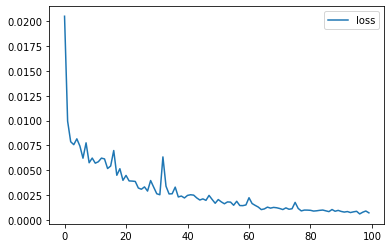

In [20]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Model 1 (LSTM): predictions 

In [21]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(data=true_predictions,index=test.index,columns=test.columns)
true_predictions.head()

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10527.688114,50444.344784,45415.243730,6573.605566
2019-03-01,12946.091331,57923.157099,52957.199336,7691.428199
2019-04-01,12614.593914,56039.067476,50413.062319,7512.376486
2019-05-01,13693.593456,57221.481522,49666.334395,7578.500745
2019-06-01,14570.714795,54575.763199,53395.460611,7856.815342


In [23]:
true_predictions

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10527.688114,50444.344784,45415.243730,6573.605566
2019-03-01,12946.091331,57923.157099,52957.199336,7691.428199
2019-04-01,12614.593914,56039.067476,50413.062319,7512.376486
2019-05-01,13693.593456,57221.481522,49666.334395,7578.500745
2019-06-01,14570.714795,54575.763199,53395.460611,7856.815342
2019-07-01,12126.492671,54405.005226,50480.828827,7616.278968
2019-08-01,13966.132468,58192.077850,56139.971464,8566.588943
2019-09-01,12046.149130,54821.797748,56207.892581,7645.329450
2019-10-01,13720.986392,58975.033863,59015.843851,8515.024747


In [24]:
test.head()

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10976.0,50825.0,42795,7067
2019-03-01,12472.0,57756.0,50552,7729
2019-04-01,13098.0,58685.0,45084,7544
2019-05-01,14573.0,61109.0,48108,7985
2019-06-01,14277.0,56458.0,48105,8367


In [25]:
predictions = pd.concat([train,true_predictions],axis=0)

In [26]:
predictions

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
1992-01-01,3459.000000,22506.000000,8932.000000,2297.000000
1992-02-01,3458.000000,21494.000000,8779.000000,2259.000000
1992-03-01,4002.000000,23277.000000,9475.000000,2688.000000
1992-04-01,4564.000000,23154.000000,9020.000000,2612.000000
1992-05-01,4221.000000,22804.000000,8558.000000,2472.000000
...,...,...,...,...
2019-09-01,12046.149130,54821.797748,56207.892581,7645.329450
2019-10-01,13720.986392,58975.033863,59015.843851,8515.024747
2019-11-01,13607.003558,56405.019516,57635.695910,8275.754928


In [27]:
def make_plots(var='alcohol sales',date='2014-01-01'):
    fig, ax = plt.subplots(figsize=(14,6))

    ax.set_xlabel('Date')
    ax.set_ylabel(var)
    ax.plot(df.loc[date:].index, predictions.loc[date:][var], label='Predictions')
    ax.plot(df.loc[date:].index, df.loc[date:][var], label='True')
    #ax.tick_params(axis='y', labelcolor=color)

    legend = ax.legend()

#    fig.tight_layout() 
    plt.title('Predictions vs true values')
    plt.show()

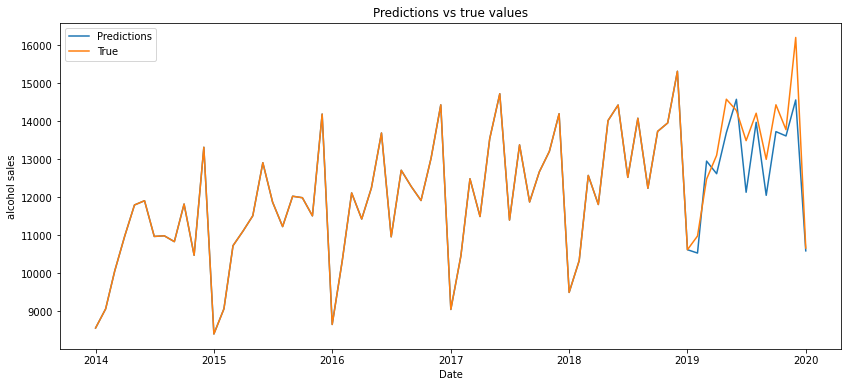

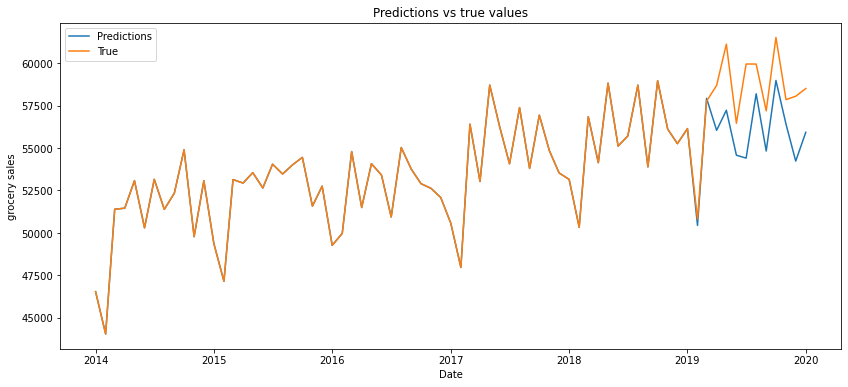

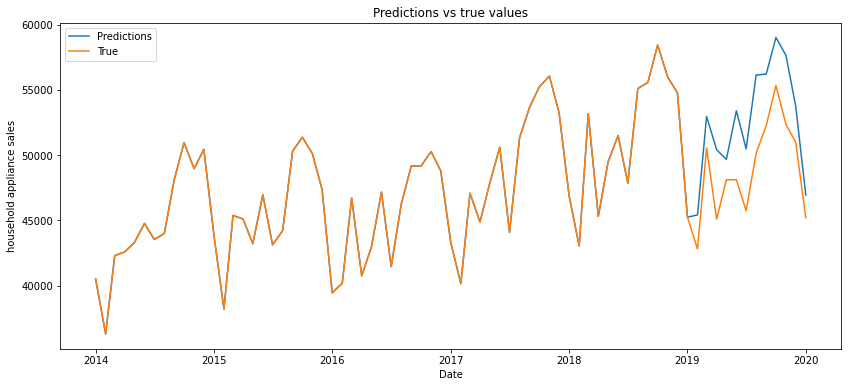

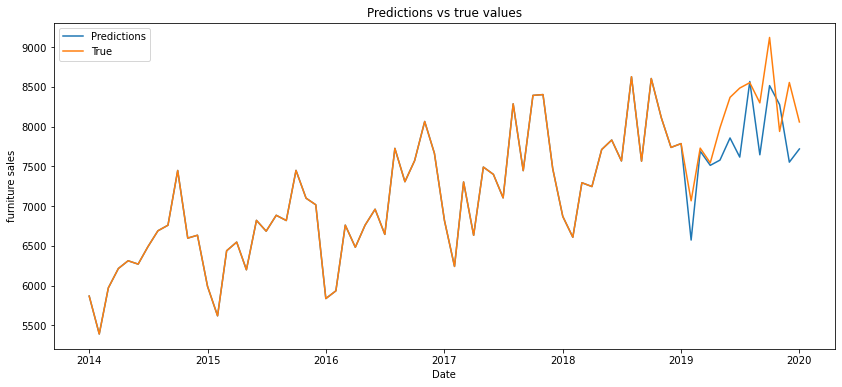

In [28]:
make_plots('alcohol sales')
make_plots('grocery sales')
make_plots('household appliance sales')
make_plots('furniture sales')

In [29]:
from sklearn.metrics import mean_squared_error

features = df.columns
RMSE = []
nRMSE = []

for feat in features:
    rmse = np.sqrt(mean_squared_error(test[feat], true_predictions[feat]))
    RMSE.append(rmse)
    nRMSE.append(rmse/train.iloc[-1][feat])

for i in range(len(RMSE)):
    print (f"{features[i]} - \tRMSE: {np.round(RMSE[i],2)}, \tnormalized to last train value: {np.round(nRMSE[i]*100,2)}%")

alcohol sales - 	RMSE: 792.93, 	normalized to last train value: 7.47%
grocery sales - 	RMSE: 2811.62, 	normalized to last train value: 5.01%
household appliance sales - 	RMSE: 4059.54, 	normalized to last train value: 8.97%
furniture sales - 	RMSE: 535.99, 	normalized to last train value: 6.88%


#### Overall, it seems that the model is able to predict the future 12-months sales with decent accuracy, at least the trend. 
Grocery and furniture sales are slightly underestimated, while household appliance sales is a bit overestimated. 
The RMSE for all categories is between 5-10% of the value of the last point in the train dataset.

## Model 2: RNN with Gated-recurrent units (GRU)

A GRU unit consists of a cell and 2 gates only:
* Reset gate: it decides which past information to keep
* Update gate: it decides what information to keep and what to throw away

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU

# define model
model = Sequential()

# 4 stacked layers
model.add(GRU(256,input_shape=(length,scaled_train.shape[1]),return_sequences=True))
model.add(GRU(256,return_sequences=True))
model.add(GRU(256,return_sequences=True))
model.add(GRU(256))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 12, 256)           201216    
_________________________________________________________________
gru_1 (GRU)                  (None, 12, 256)           394752    
_________________________________________________________________
gru_2 (GRU)                  (None, 12, 256)           394752    
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 1,386,500
Trainable params: 1,386,500
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit_generator(generator,epochs=100)

Epoch 1/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0158
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0096
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0090
Epoch 4/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0085
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0067
Epoch 6/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0053
Epoch 7/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0050
Epoch 8/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0041
Epoch 9/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 10/100
313/313 [==============================] - 2s 8ms/step - loss: 0.0037
Epoch 11/100
313/313 [==============================] - 2s 7ms/step - loss: 0.0045
Epoch 12/100
313/313 [==============================] - 3s 10ms/step - loss: 0.0036
Epoch 13/100

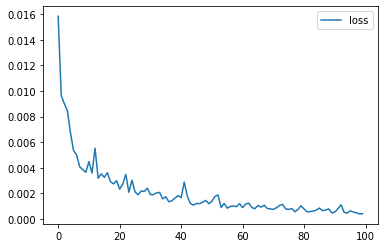

In [32]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### Model 2 (GRU): predictions

In [33]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(data=true_predictions,index=test.index,columns=test.columns)
true_predictions.head()

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10287.553173,51865.635536,44126.425370,6544.606081
2019-03-01,12300.871830,58501.968367,53397.428909,7567.327805
2019-04-01,11958.928450,55059.923127,47156.389851,7215.106557
2019-05-01,14343.348444,57687.000015,49994.323459,7533.228987
2019-06-01,13861.947984,56033.059117,49709.238515,7733.235957


In [35]:
true_predictions

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10287.553173,51865.635536,44126.425370,6544.606081
2019-03-01,12300.871830,58501.968367,53397.428909,7567.327805
2019-04-01,11958.928450,55059.923127,47156.389851,7215.106557
2019-05-01,14343.348444,57687.000015,49994.323459,7533.228987
2019-06-01,13861.947984,56033.059117,49709.238515,7733.235957
2019-07-01,12424.447388,54398.319774,46420.535133,7287.324974
2019-08-01,13477.943413,58992.782254,53638.634504,8107.485685
2019-09-01,11686.232840,54760.164264,52308.609755,7426.331755
2019-10-01,13383.543375,58352.965108,55889.162244,8440.536576


In [36]:
test.head()

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
2019-02-01,10976.0,50825.0,42795,7067
2019-03-01,12472.0,57756.0,50552,7729
2019-04-01,13098.0,58685.0,45084,7544
2019-05-01,14573.0,61109.0,48108,7985
2019-06-01,14277.0,56458.0,48105,8367


In [37]:
predictions = pd.concat([train,true_predictions],axis=0)

In [38]:
predictions

,alcohol sales,grocery sales,household appliance sales,furniture sales
DATE,,,,
1992-01-01,3459.000000,22506.000000,8932.000000,2297.000000
1992-02-01,3458.000000,21494.000000,8779.000000,2259.000000
1992-03-01,4002.000000,23277.000000,9475.000000,2688.000000
1992-04-01,4564.000000,23154.000000,9020.000000,2612.000000
1992-05-01,4221.000000,22804.000000,8558.000000,2472.000000
...,...,...,...,...
2019-09-01,11686.232840,54760.164264,52308.609755,7426.331755
2019-10-01,13383.543375,58352.965108,55889.162244,8440.536576
2019-11-01,13792.403849,56258.270235,53612.556054,7926.238051


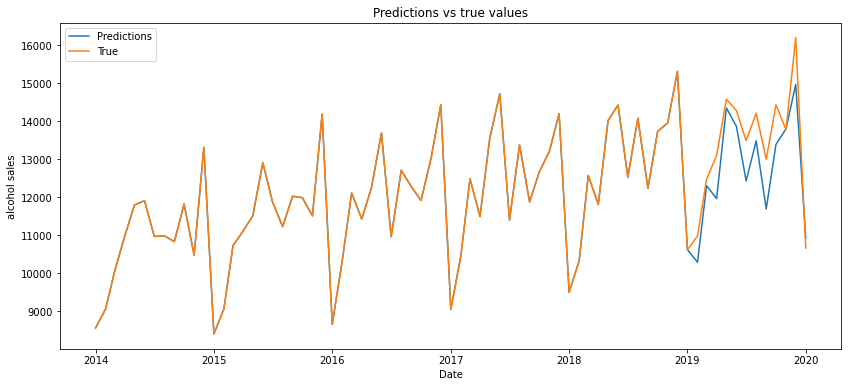

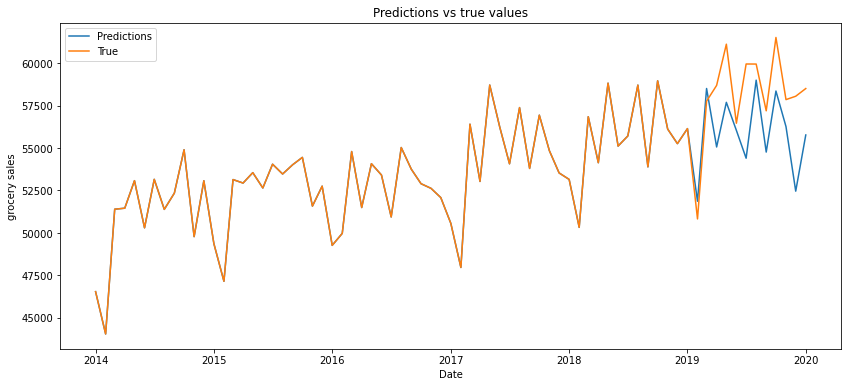

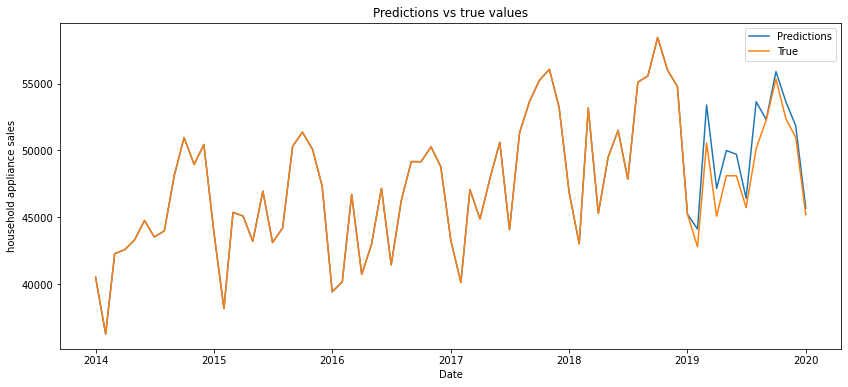

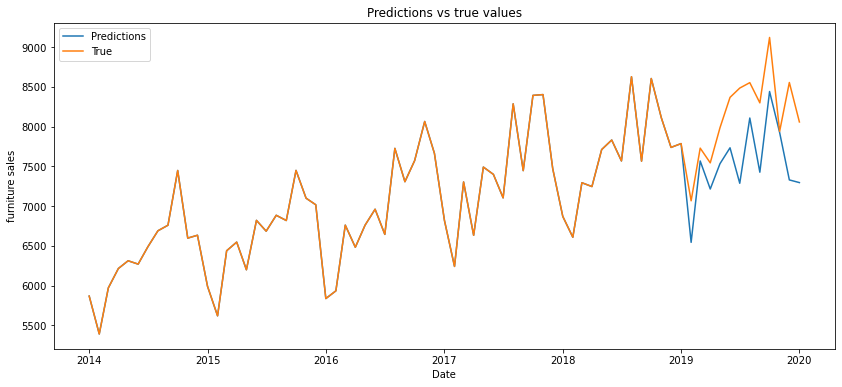

In [39]:
make_plots('alcohol sales')
make_plots('grocery sales')
make_plots('household appliance sales')
make_plots('furniture sales')

In [40]:
from sklearn.metrics import mean_squared_error

features = df.columns
RMSE = []
nRMSE = []

for feat in features:
    rmse = np.sqrt(mean_squared_error(test[feat], true_predictions[feat]))
    RMSE.append(rmse)
    nRMSE.append(rmse/train.iloc[-1][feat])

for i in range(len(RMSE)):
    print (f"{features[i]} - \tRMSE: {np.round(RMSE[i],2)}, \tnormalized to last train value: {np.round(nRMSE[i]*100,2)}%")

alcohol sales - 	RMSE: 819.51, 	normalized to last train value: 7.72%
grocery sales - 	RMSE: 3100.48, 	normalized to last train value: 5.52%
household appliance sales - 	RMSE: 1728.23, 	normalized to last train value: 3.82%
furniture sales - 	RMSE: 703.84, 	normalized to last train value: 9.04%


#### Performances of model 2 (GRU) are similar to those of model 1 (LSTM). 

It seems GRU model outperforms LSTM model in household appliance category - however, it performs worse in predictions of furniture sales. 

#### Overall, performances of the two models are similar, and RMSE is always less than 10% of the last value in the train dataset.